# Explore training dataset

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns

import crunchy_snow.dataset

In [2]:
# grab data paths
data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v2/train'
path_list = glob(f'{data_dir}/ASO_50M_SD*.nc')

The "selected channels" list contains all the data currently in our dataset, which we could potentially use to train our model. 

In [3]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = crunchy_snow.dataset.Dataset(path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)

The code below can be used to visualize a selection of the normalized data in our dataset. 

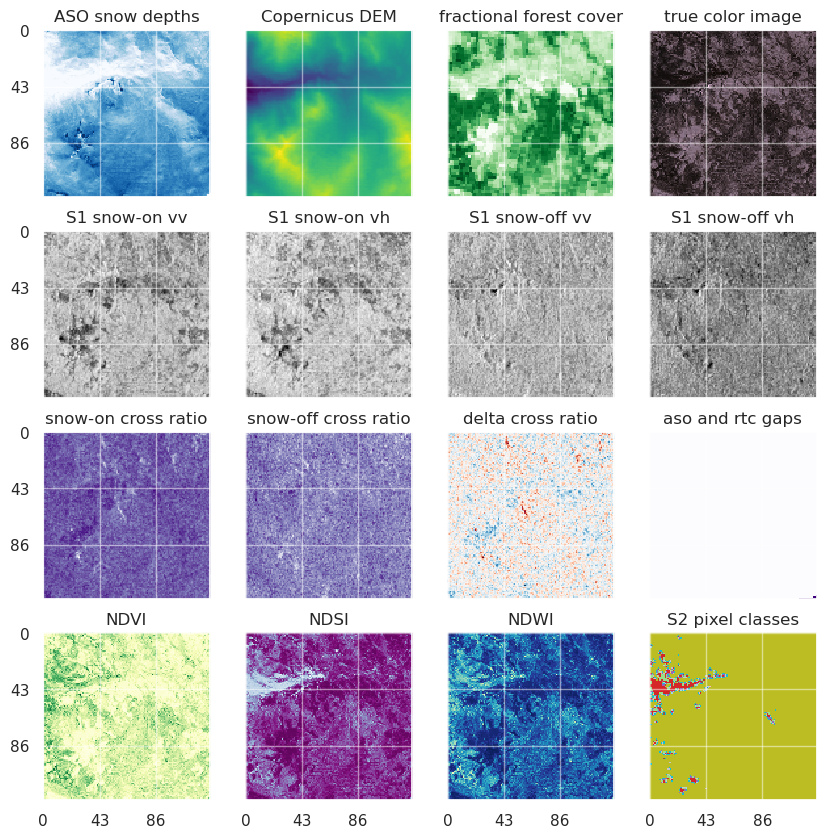

In [20]:
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(train_loader):
    if i < num_samples:
        data_dict = {name: tensor.squeeze() for name, tensor in zip(selected_channels, data_tuple)}
        f, ax = plt.subplots(4, 4, figsize=(10, 10), sharey=True, sharex=True)
        
        ax[0, 0].imshow(data_dict['aso_sd'], vmin=0, vmax=0.2, cmap='Blues', interpolation='none')
        ax[0, 0].set_title('ASO snow depths')
        ax[0, 1].imshow(data_dict['elevation'], cmap='viridis', interpolation='none')
        ax[0, 1].set_title('Copernicus DEM')
        ax[0, 2].imshow(data_dict['fcf'], cmap='Greens', interpolation='none')
        ax[0, 2].set_title('fractional forest cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[0, 3].imshow(torch.cat((data_dict['red'][:, :, None]/norm_max, data_dict['green'][:, :, None]/norm_max, data_dict['blue'][:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[0, 3].set_title('true color image')
        ax[1, 0].imshow(data_dict['snowon_vv'], cmap='Greys_r', interpolation='none')
        ax[1, 0].set_title('S1 snow-on vv')
        ax[1, 1].imshow(data_dict['snowon_vh'], cmap='Greys_r', interpolation='none')
        ax[1, 1].set_title('S1 snow-on vh')
        ax[1, 2].imshow(data_dict['snowoff_vv'], cmap='Greys_r', interpolation='none')
        ax[1, 2].set_title('S1 snow-off vv')
        ax[1, 3].imshow(data_dict['snowoff_vh'], cmap='Greys_r', interpolation='none')
        ax[1, 3].set_title('S1 snow-off vh')
        ax[2, 0].imshow(data_dict['snowon_cr'], cmap='Purples', interpolation='none')
        ax[2, 0].set_title('snow-on cross ratio')
        ax[2, 1].imshow(data_dict['snowoff_cr'], cmap='Purples', interpolation='none')
        ax[2, 1].set_title('snow-off cross ratio')
        ax[2, 2].imshow(data_dict['delta_cr'], cmap='RdBu', interpolation='none')
        ax[2, 2].set_title('delta cross ratio')
        ax[2, 3].imshow(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'], cmap='Purples', interpolation='none')
        ax[2, 3].set_title('aso and rtc gaps')
        ax[3, 0].imshow(data_dict['ndvi'], cmap='YlGn', interpolation='none')
        ax[3, 0].set_title('NDVI')
        ax[3, 1].imshow(data_dict['ndsi'], cmap='BuPu', interpolation='none')
        ax[3, 1].set_title('NDSI')
        ax[3, 2].imshow(data_dict['ndwi'], cmap='YlGnBu', interpolation='none')
        ax[3, 2].set_title('NDWI')
        ax[3, 2].imshow(data_dict['ndwi'], cmap='YlGnBu', interpolation='none')
        ax[3, 2].set_title('NDWI')
        ax[3, 3].imshow(data_dict['scene_class_map'], cmap='tab20', interpolation='none')
        ax[3, 3].set_title('S2 pixel classes')
        ax[0, 0].set_aspect('equal')
        
        # Set gridlines at intervals
        for a in ax.flat:
            a.set_xticks(np.arange(0, data_dict['aso_sd'].shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        # f.tight_layout()
    else:
        break